In this notebook we will explore Pycaret to make stock prediction. 

In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

from pycaret.time_series import *
from sktime.forecasting.all import *

In [22]:
stock_list = ['MSFT', 'MMC', 'NI', 'BAX', 'CNP', 'TGT', 'JPM', 'BA']
start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 1, 1)
#or end_date= datetime.today().strftime(%Y-%m-%d)
data = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']
data.head()

BA        BAX        CNP        JPM        MMC       MSFT  \
Date                                                                            
2018-01-02  282.886383  62.587017  23.614426  92.699570  73.658829  80.738182   
2018-01-03  283.801300  63.593346  23.563864  92.794037  74.620766  81.113922   
2018-01-04  282.724396  63.742428  23.589146  94.123383  75.399521  81.827820   
2018-01-05  294.322327  64.459892  23.488010  93.519119  75.921715  82.842339   
2018-01-08  295.570770  64.553055  23.631285  93.657249  75.115494  82.926872   

                   NI        TGT  
Date                              
2018-01-02  21.367815  59.679726  
2018-01-03  21.233004  59.273808  
2018-01-04  21.140318  58.108974  
2018-01-05  20.887547  58.726688  
2018-01-08  21.064486  59.282616

In [23]:
df=data[['MSFT']]

Adjust the indices to period. 

In [24]:
df.index=df.index.to_period('B')
idx=pd.period_range(min(df.index),max(df.index))
df.index.symmetric_difference(idx)
df = df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')
df.tail()

MSFT
2022-12-26  238.133545
2022-12-27  236.367981
2022-12-28  233.944031
2022-12-29  240.407837
2022-12-30  239.220825

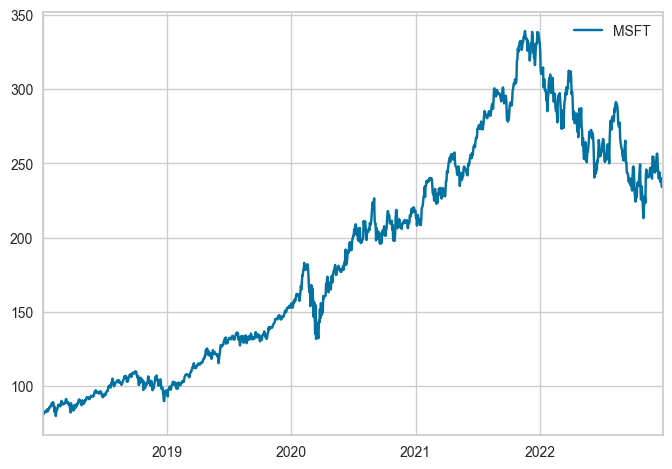

In [25]:
df.plot()
plt.show()

Using the past 6 months data to make prediction for the next month and moving half a year forward

In [26]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

In [27]:
exp = TSForecastingExperiment()

# using the past 6 months data to make prediction for the next month and moving half a year forward. 
exp.setup(data = df, target='MSFT' ,coverage=0.90, fold_strategy=SlidingWindowSplitter(fh=np.arange(1,23), window_length=130, step_length=130)) 



Plot the model

In [28]:
exp.plot_model(plot='train_test_split')

In [29]:
exp.plot_model(plot='cv')

Get the best result

In [30]:
exp.compare_models(sort='rmse')

Initiated  . . . . . . . . . . . . . . . . . .           15:51:09
Status     . . . . . . . . . . . . . . . . . .  Loading Estimator
Estimator  . . . . . . . . . . . . . . . . . .   Naive Forecaster

We can see classical machine learning models and statistical ones . Based on RMSE and MAE we see that ARIMA scores the best!  

The machine learning models are written with an underscore _cds which means 'conditional deseasonalized and detrended'.  

We see that R^² is quite low -2 . The meaning of this is that taking an average is even better than using a model =) 

Why not showing everything? 

TSForecastingExperiment' object is not subscriptable
https://developers.refinitiv.com/en/article-catalog/article/modelling-and-evaluation-using-pycaret-on-time-series-data

In [19]:
my_models=['arima','naive','knn_cds_dt','gbr_cds_dt']
exp.compare_models(include=my_models, sort='rmse')

Initiated  . . . . . . . . . . . . . . . . . .         10:38:59
Status     . . . . . . . . . . . . . . . . . .  Fitting 9 Folds
Estimator  . . . . . . . . . . . . . . . . . .            ARIMA

ARIMA(seasonal_order=(0, 1, 0, 9))

Tuning

In [ ]:
#Also try scikitlearn timeseries split with gap 

Let's go for lowest R²

Read documentation to adjust! https://sktime.readthedocs.io/en/latest/api_reference/forecasting.html?highlight=ets#exponential-smoothing-based-forecasters

In [20]:
ets=exp.create_model('ets')

Initiated  . . . . . . . . . . . . . . . . . .         10:39:43
Status     . . . . . . . . . . . . . . . . . .  Fitting 9 Folds
Estimator  . . . . . . . . . . . . . . . . . .              ETS

We did 9 fold.

In [23]:
tuned_ets = exp.tune_model(ets)

Fitting 9 folds for each of 10 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s


In [29]:
tuned_ets

AutoETS(error='mul', seasonal='add', sp=9, trend='add')

Let's have a look into tuned_ets (meaning). Which has a good value ? 
It has seasonality, the period of seasonality is 9 . Trend is multipolicated

In [33]:
exp.plot_model(estimator=tuned_ets, plot="diagnostics")

Let's have a look into insample predictions. You can zoom into the Actual and forecast! 

In [36]:
exp.plot_model(tuned_ets, plot='insample')

In [35]:
exp.plot_model(tuned_ets, plot='forecast', data_kwargs={'fh':36})

Outsample example

In [39]:
exp.plot_model(gbr, plot='forecast', data_kwargs={'fh':36})

This graph explains the negative R² (as it's doing worse than simple average)

Predict model

In [41]:
pred=exp.predict_model(tuned_ets)
pred

y_pred
2022-12-01  251.6938
2022-12-02  251.7222
2022-12-05  251.8867
2022-12-06  251.6756
2022-12-07  252.0825
2022-12-08  252.0163
2022-12-09  251.8828
2022-12-12  252.5221
2022-12-13  252.8905
2022-12-14  253.1306
2022-12-15  253.1590
2022-12-16  253.3235
2022-12-19  253.1124
2022-12-20  253.5193
2022-12-21  253.4531
2022-12-22  253.3196
2022-12-23  253.9589
2022-12-26  254.3273
2022-12-27  254.5674
2022-12-28  254.5958
2022-12-29  254.7602
2022-12-30  254.5492

Finalize model. Train on whole dataset. 



In [42]:
final_model = exp.finalize_model(tuned_ets)
exp.plot_model(final_model, plot='forecast', data_kwargs={'fh':24})
unseen_predictions = exp.predict_model(final_model, fh=10)
unseen_predictions

y_pred
2023-01-02  239.8164
2023-01-03  239.5627
2023-01-04  238.9493
2023-01-05  239.9215
2023-01-06  240.5694
2023-01-09  241.0563
2023-01-10  240.5743
2023-01-11  241.1718
2023-01-12  240.4890
2023-01-13  241.2128